# Pneumonia Detection — Project Notebook

This notebook is the primary workspace for the academic project: binary classification of chest X-ray images (PNEUMONIA vs NORMAL).

**Goals in this notebook:**
- Combine images from `train`, `val`, and `test` into two class folders (`NORMAL`, `PNEUMONIA`).
- Produce a cleaned dataset directory for preprocessing and model training.
- Report counts and list problematic images (non-standard modes, very small sizes).

Notes: this file contains runnable Python cells. Run cells sequentially in a Python kernel (recommend Python 3.8+).

## Environment & Requirements
Run this environment cell first. Required packages: `Pillow` (PIL).
If you need to install: `pip install pillow`

Adjust `BASE_DIR` below if your workspace root differs.

In [ ]:
from pathlib import Path
import shutil
from PIL import Image
from collections import Counter
import sys

# Adjust this base directory if needed
BASE_DIR = Path(r'd:/Project')
SRC_DIR = BASE_DIR / 'chest_xray'
OUTPUT_DIR = BASE_DIR / 'chest_xray_combined'
NORMAL_DIR = OUTPUT_DIR / 'NORMAL'
PNEUMONIA_DIR = OUTPUT_DIR / 'PNEUMONIA'

OUTPUT_DIR.mkdir(exist_ok=True)
for d in (NORMAL_DIR, PNEUMONIA_DIR):
    d.mkdir(exist_ok=True)

print('Source directory:', SRC_DIR)
print('Output directory:', OUTPUT_DIR)


Source directory: d:\University_Large_files\Project\chest_xray
Output directory: d:\University_Large_files\Project\chest_xray_combined


In [2]:
# Combine images from train/val/test into two folders.
from pathlib import Path
import shutil

split_names = ['train', 'val', 'test']
class_names = ['NORMAL', 'PNEUMONIA']
copied = { 'NORMAL': 0, 'PNEUMONIA': 0 }

def _unique_dest(dest_dir: Path, name: str) -> Path:
    dest = dest_dir / name
    if not dest.exists():
        return dest
    # if collision, append numeric suffix
    stem = Path(name).stem
    suffix = Path(name).suffix
    i = 1
    while True:
        candidate = dest_dir / f"{stem}__{i}{suffix}"
        if not candidate.exists():
            return candidate
        i += 1

for split in split_names:
    for cls in class_names:
        src_folder = SRC_DIR / split / cls
        if not src_folder.exists():
            # skip missing splits/classes gracefully
            continue
        for f in src_folder.iterdir():
            if not f.is_file():
                continue
            dest_dir = NORMAL_DIR if cls == 'NORMAL' else PNEUMONIA_DIR
            # prefix filename with split to reduce collisions
            new_name = f"{split}_{f.name}"
            dest_path = _unique_dest(dest_dir, new_name)
            shutil.copy2(f, dest_path)
            copied[cls] += 1

print('Copied counts:', copied)


Copied counts: {'NORMAL': 1583, 'PNEUMONIA': 4273}


In [3]:
# Quick dataset inspection: counts, image modes(channels 'L' or 'RGB'), small images (<=299 in any dimension)
from collections import Counter

modes = Counter()
sizes_le_299 = []
errors = []
total = 0
for cls_dir in (NORMAL_DIR, PNEUMONIA_DIR):
    for p in cls_dir.iterdir():
        if not p.is_file():
            continue
        total += 1
        try:
            with Image.open(p) as im:
                modes[im.mode] += 1
                if im.size[0] <= 299 or im.size[1] <= 299:
                    sizes_le_299.append(str(p))
        except Exception as e:
            errors.append((str(p), str(e)))

print('Total files in combined folder:', total)
print('Image modes summary:', modes)
print('Number of files with any dimension <=299:', len(sizes_le_299))
if errors:
    print('Errors reading some files:', len(errors))

# Show up to 10 small files for review
sizes_le_299[:10]


Total files in combined folder: 5856
Image modes summary: Counter({'L': 5573, 'RGB': 283})
Number of files with any dimension <=299: 76


['d:\\University_Large_files\\Project\\chest_xray_combined\\PNEUMONIA\\train_person1308_bacteria_3292.jpeg',
 'd:\\University_Large_files\\Project\\chest_xray_combined\\PNEUMONIA\\train_person1311_bacteria_3312.jpeg',
 'd:\\University_Large_files\\Project\\chest_xray_combined\\PNEUMONIA\\train_person1642_bacteria_4352.jpeg',
 'd:\\University_Large_files\\Project\\chest_xray_combined\\PNEUMONIA\\train_person1668_bacteria_4421.jpeg',
 'd:\\University_Large_files\\Project\\chest_xray_combined\\PNEUMONIA\\train_person1669_bacteria_4422.jpeg',
 'd:\\University_Large_files\\Project\\chest_xray_combined\\PNEUMONIA\\train_person1670_bacteria_4426.jpeg',
 'd:\\University_Large_files\\Project\\chest_xray_combined\\PNEUMONIA\\train_person1676_bacteria_4441.jpeg',
 'd:\\University_Large_files\\Project\\chest_xray_combined\\PNEUMONIA\\train_person1677_bacteria_4443.jpeg',
 'd:\\University_Large_files\\Project\\chest_xray_combined\\PNEUMONIA\\train_person1677_bacteria_4444.jpeg',
 'd:\\University_La

## Next steps
- Inspect the small or problematic images listed above and decide whether to remove or replace them.
- Decide whether to convert images to single-channel (grayscale) or retain RGB for transfer learning with pretrained networks.
- Apply augmentation and construct training/validation pipelines (recommended: EfficientNet-B0 or InceptionResNet backbones with appropriate regularization).
- Track experiments and validation performance to avoid overfitting (cross-validation folds, early stopping, and ensemble strategies).

The following cell permanently removes images that do not meet dataset criteria (RGB mode or any dimension <= 299). This operation is irreversible

In [ ]:
# Permanently remove images with mode 'RGB' or any dimension <= 299.
# Improved: retry on PermissionError (Windows "file in use") and report files that could not be removed.
from pathlib import Path
from collections import Counter
from PIL import Image
import time
import traceback

OUTPUT_DIR = Path(r'd:/Project/chest_xray_combined')
NORMAL_DIR = OUTPUT_DIR / 'NORMAL'
PNEUMONIA_DIR = OUTPUT_DIR / 'PNEUMONIA'

removed_mode = 0
removed_size = 0
remove_failures = []
open_errors = []

def try_unlink(p: Path, retries=5, delay=0.5):
    """Attempt to unlink a file with retries on PermissionError. Returns True on success."""
    for i in range(retries):
        try:
            p.unlink()
            return True
        except PermissionError as e:
            time.sleep(delay)
        except Exception as e:
            # non-permission error — record and stop retrying
            remove_failures.append((str(p), str(e)))
            return False
    # final attempt
    try:
        p.unlink()
        return True
    except Exception as e:
        remove_failures.append((str(p), str(e)))
        return False

for cls_dir in (NORMAL_DIR, PNEUMONIA_DIR):
    for p in list(cls_dir.iterdir()):
        if not p.is_file():
            continue
        try:
            # Open and inspect image, then close before attempting deletion
            with Image.open(p) as im:
                mode = im.mode
                size = im.size
            # If image mode is RGB, attempt to remove
            if mode == 'RGB':
                ok = try_unlink(p)
                if ok:
                    removed_mode += 1
                continue
            # If any dimension <= 299, attempt to remove
            if size[0] <= 299 or size[1] <= 299:
                ok = try_unlink(p)
                if ok:
                    removed_size += 1
        except Exception as e:
            # Could be a permission error while opening or other issues
            open_errors.append((str(p), str(e)))

# Recompute summary after deletions, skipping files that cannot be opened
modes = Counter()
total = 0
reopen_errors = []
for cls_dir in (NORMAL_DIR, PNEUMONIA_DIR):
    for p in cls_dir.iterdir():
        if not p.is_file():
            continue
        try:
            with Image.open(p) as im:
                modes[im.mode] += 1
            total += 1
        except Exception as e:
            reopen_errors.append((str(p), str(e)))

print('Count permanently removed (mode=RGB):', removed_mode)
print('Count permanently removed (size <= 299):', removed_size)
print('Total remaining files in combined folder:', total)
print('Image modes summary after removal:', modes)

# Consolidate and display failures
all_failures = remove_failures + open_errors + reopen_errors
if all_failures:
    print('Number of file errors (open/remove):', len(all_failures))
    print('Examples (up to 50):')
    for item in all_failures[:50]:
        print(item)
else:
    print('No file errors encountered during removal and re-scan.')


Count permanently removed (mode=RGB): 283
Count permanently removed (size <= 299): 0
Total remaining files in combined folder: 5573
Image modes summary after removal: Counter({'L': 5573})
No file errors encountered during removal and re-scan.


Clarification: The previously reported count "size <= 299: 0" reflects zero remaining small images in the combined folder because those small images were included among the 283 files that were removed for having mode 'RGB' during the earlier removal operation.

In [ ]:
# Print class label counts in the combined dataset folder
from pathlib import Path

COMBINED_DIR = Path(r'd:/Project/chest_xray_combined')
counts = {}
for cls in ('NORMAL', 'PNEUMONIA'):
    p = COMBINED_DIR / cls
    if p.exists():
        counts[cls] = sum(1 for f in p.iterdir() if f.is_file())
    else:
        counts[cls] = 0

total = sum(counts.values())
print('Class counts in `chest_xray_combined`:')
for k, v in counts.items():
    if total:
        print(f"- {k}: {v} ({v/total:.2%} of total)")
    else:
        print(f"- {k}: {v}")
print(f'Total images: {total}')


Class counts in `chest_xray_combined`:
- NORMAL: 1583 (28.40% of total)
- PNEUMONIA: 3990 (71.60% of total)
Total images: 5573


In [ ]:
# Resize all images in `chest_xray_combined` to 299x299 and save to `chest_xray_299`.
# Converts images to RGB to ensure a consistent 3-channel input for common pretrained backbones.
from pathlib import Path
from PIL import Image

BASE_DIR = Path(r'd:/Project')
COMBINED_DIR = BASE_DIR / 'chest_xray_combined'
RESIZED_DIR = BASE_DIR / 'chest_xray_299'
TARGET_SIZE = (299, 299)
FORCE_OVERWRITE = False  # set True to regenerate existing files

for cls in ('NORMAL', 'PNEUMONIA'):
    (RESIZED_DIR / cls).mkdir(parents=True, exist_ok=True)

written = 0
failures = []

for cls in ('NORMAL', 'PNEUMONIA'):
    src_dir = COMBINED_DIR / cls
    out_dir = RESIZED_DIR / cls
    if not src_dir.exists():
        print(f"Warning: source folder not found: {src_dir}")
        continue
    files = [p for p in src_dir.iterdir() if p.is_file()]
    print(f"Processing class {cls}: {len(files)} files")
    for i, p in enumerate(files, 1):
        out_path = out_dir / p.name
        if out_path.exists() and not FORCE_OVERWRITE:
            continue
        try:
            with Image.open(p) as im:
                # Convert to RGB to ensure 3 channels
                im2 = im.convert('RGB')
                imr = im2.resize(TARGET_SIZE, Image.LANCZOS)
                imr.save(out_path, quality=95)
                written += 1
        except Exception as e:
            failures.append((str(p), str(e)))
        if i % 500 == 0:
            print(f"  Processed {i}/{len(files)} in {cls}...")

print('\nResize complete')
print('Images written:', written)
print('Target folder:', RESIZED_DIR)
if failures:
    print('Failures:', len(failures))
    for f in failures[:20]:
        print(f)
else:
    print('No failures encountered')


Processing class NORMAL: 1583 files
  Processed 500/1583 in NORMAL...
  Processed 500/1583 in NORMAL...
  Processed 1000/1583 in NORMAL...
  Processed 1000/1583 in NORMAL...
  Processed 1500/1583 in NORMAL...
  Processed 1500/1583 in NORMAL...
Processing class PNEUMONIA: 3990 files
Processing class PNEUMONIA: 3990 files
  Processed 500/3990 in PNEUMONIA...
  Processed 500/3990 in PNEUMONIA...
  Processed 1000/3990 in PNEUMONIA...
  Processed 1000/3990 in PNEUMONIA...
  Processed 1500/3990 in PNEUMONIA...
  Processed 1500/3990 in PNEUMONIA...
  Processed 2000/3990 in PNEUMONIA...
  Processed 2000/3990 in PNEUMONIA...
  Processed 2500/3990 in PNEUMONIA...
  Processed 2500/3990 in PNEUMONIA...
  Processed 3000/3990 in PNEUMONIA...
  Processed 3000/3990 in PNEUMONIA...
  Processed 3500/3990 in PNEUMONIA...
  Processed 3500/3990 in PNEUMONIA...

Resize complete
Images written: 5573
Target folder: d:\University_Large_files\Project\chest_xray_299
No failures encountered

Resize complete
Image

In [ ]:
# Compute pixel value ranges across the dataset (per-channel and overall)
# Prefers `chest_xray_299` if present, otherwise uses `chest_xray_combined`.
# This version detects image modes and handles grayscale ('L') datasets specially.
from pathlib import Path
from collections import Counter

BASE_DIR = Path(r'd:/Project')
PREFERRED_DIRS = ['chest_xray_299', 'chest_xray_combined']
DATA_DIR = None
for d in PREFERRED_DIRS:
    candidate = BASE_DIR / d
    if candidate.exists():
        DATA_DIR = candidate
        break

if DATA_DIR is None:
    print('No dataset folder found. Ensure one of the following exists under BASE_DIR:', PREFERRED_DIRS)
else:
    print('Scanning images in:', DATA_DIR)
    try:
        import numpy as np
        from PIL import Image
    except Exception as e:
        print('Missing dependency:', e)
        print('Install required packages: pip install pillow numpy')
        raise

    overall_min = 255
    overall_max = 0
    channel_mins = None
    channel_maxs = None
    file_count = 0
    errors = []
    modes = Counter()

    for cls in ('NORMAL','PNEUMONIA'):
        folder = DATA_DIR / cls
        if not folder.exists():
            continue
        for p in folder.iterdir():
            if not p.is_file():
                continue
            try:
                with Image.open(p) as im:
                    modes[im.mode] += 1
                    arr = np.array(im)
                    if arr.size == 0:
                        continue
                    mn = int(arr.min())
                    mx = int(arr.max())
                    overall_min = min(overall_min, mn)
                    overall_max = max(overall_max, mx)
                    if arr.ndim == 2:
                        # grayscale
                        if channel_mins is None:
                            channel_mins = [mn]
                            channel_maxs = [mx]
                        else:
                            channel_mins[0] = min(channel_mins[0], mn)
                            channel_maxs[0] = max(channel_maxs[0], mx)
                    else:
                        # H x W x C
                        ch_mins = arr.min(axis=(0,1))
                        ch_maxs = arr.max(axis=(0,1))
                        if channel_mins is None:
                            channel_mins = [int(x) for x in ch_mins]
                            channel_maxs = [int(x) for x in ch_maxs]
                        else:
                            for i in range(min(len(channel_mins), len(ch_mins))):
                                channel_mins[i] = min(channel_mins[i], int(ch_mins[i]))
                                channel_maxs[i] = max(channel_maxs[i], int(ch_maxs[i]))
                            if len(ch_mins) > len(channel_mins):
                                for j in range(len(channel_mins), len(ch_mins)):
                                    channel_mins.append(int(ch_mins[j]))
                                    channel_maxs.append(int(ch_maxs[j]))
                    file_count += 1
            except Exception as e:
                errors.append((str(p), str(e)))

    print('\nFiles scanned:', file_count)
    print('Image modes summary:', dict(modes))
    print('Overall pixel range: {} .. {}'.format(overall_min, overall_max))

    # Special note for grayscale-only datasets
    if len(modes) == 1 and 'L' in modes:
        if channel_mins is not None:
            print('All images are grayscale (mode L). Single-channel range: {} .. {}'.format(channel_mins[0], channel_maxs[0]))
        else:
            print('All images are grayscale (mode L), but channel stats not available.')
    else:
        if channel_mins is not None:
            for i, (cmin, cmax) in enumerate(zip(channel_mins, channel_maxs)):
                print(f'Channel {i} range: {cmin} .. {cmax}')
        else:
            print('No channel data collected (no images found?)')

    if errors:
        print('\nErrors reading some files (examples up to 20):')
        for e in errors[:20]:
            print(e)


Scanning images in: d:\University_Large_files\Project\chest_xray_299

Files scanned: 5573
Image modes summary: {'RGB': 5573}
Overall pixel range: 0 .. 255
Channel 0 range: 0 .. 255
Channel 1 range: 0 .. 255
Channel 2 range: 0 .. 255

Files scanned: 5573
Image modes summary: {'RGB': 5573}
Overall pixel range: 0 .. 255
Channel 0 range: 0 .. 255
Channel 1 range: 0 .. 255
Channel 2 range: 0 .. 255


### Note on RGB conversion and planned grayscale copy

- Rationale for RGB: For compatibility with common pretrained convolutional backbones (e.g., EfficientNet, Inception, ResNet), resized images were converted to RGB (3 channels) during the resizing step. Using 3-channel RGB images lets us directly use pretrained weights and transfer-learning workflows, which typically yield stronger performance and faster convergence on small medical datasets.

- Trade-offs: Converting grayscale X‑rays to RGB increases model compatibility but does not add diagnostic color information — the three channels will contain duplicated grayscale data. Using a single-channel (grayscale) pipeline can reduce storage and model parameters and is appropriate when training from scratch or for models that explicitly accept single-channel input.

- Project plan: The `chest_xray_299` folder currently contains RGB images (this is expected). To preserve an option for grayscale experiments and to document reproducibility, the next notebook cell will create a separate copy named `chest_xray_299_gray` where all images are resized to 299×299 and saved in single-channel (`L`) format. The RGB folder will be kept unchanged to support transfer-learning experiments.

(Record added for reproducibility and to explain design choices in the final report.)

In [ ]:
# Generate a grayscale (single-channel) 299x299 copy into `chest_xray_299_gray`
# Source: `chest_xray_combined` (post-cleaning). RGB folder is preserved.
from pathlib import Path
from PIL import Image

BASE = Path(r'd:/Project')
SRC = BASE / 'chest_xray_combined'
OUT = BASE / 'chest_xray_299_gray'
TARGET = (299, 299)
FORCE = False  # set True to overwrite existing files

for cls in ('NORMAL', 'PNEUMONIA'):
    (OUT / cls).mkdir(parents=True, exist_ok=True)

written = 0
errors = []

for cls in ('NORMAL', 'PNEUMONIA'):
    src_dir = SRC / cls
    out_dir = OUT / cls
    if not src_dir.exists():
        print(f'Warning: source folder not found: {src_dir}')
        continue
    files = [p for p in src_dir.iterdir() if p.is_file()]
    print(f'Processing class {cls}: {len(files)} files')
    for i, p in enumerate(files, 1):
        outp = out_dir / p.name
        if outp.exists() and not FORCE:
            continue
        try:
            with Image.open(p) as im:
                g = im.convert('L')
                r = g.resize(TARGET, Image.LANCZOS)
                r.save(outp, quality=95)
                written += 1
        except Exception as e:
            errors.append((str(p), str(e)))
        if i % 500 == 0:
            print(f'  Processed {i}/{len(files)} in {cls}...')

print('\nGrayscale generation complete')
print('Images written:', written)
print('Target folder:', OUT)
if errors:
    print('Failures:', len(errors))
    for f in errors[:20]:
        print(f)
else:
    print('No failures encountered')


Processing class NORMAL: 1583 files
  Processed 500/1583 in NORMAL...
  Processed 1000/1583 in NORMAL...
  Processed 1500/1583 in NORMAL...
Processing class PNEUMONIA: 3990 files
  Processed 500/3990 in PNEUMONIA...
  Processed 1000/3990 in PNEUMONIA...
  Processed 1500/3990 in PNEUMONIA...
  Processed 2000/3990 in PNEUMONIA...
  Processed 2500/3990 in PNEUMONIA...
  Processed 3000/3990 in PNEUMONIA...
  Processed 3500/3990 in PNEUMONIA...

Grayscale generation complete
Images written: 5573
Target folder: d:\University_Large_files\Project\chest_xray_299_gray
No failures encountered


In [ ]:
# Create normalized [0,1] .npy copies for `chest_xray_299` (RGB)
# Output folder: `chest_xray_299_norm` with per-image .npy files containing float32 arrays in [0,1].
from pathlib import Path
import numpy as np
from PIL import Image

BASE = Path(r'd:/Project')
SRC = BASE / 'chest_xray_299'
OUT = BASE / 'chest_xray_299_norm'
FORCE = False  # set True to overwrite

OUT.mkdir(parents=True, exist_ok=True)
for cls in ('NORMAL','PNEUMONIA'):
    (OUT/cls).mkdir(parents=True, exist_ok=True)

written = 0
errors = []
manifest = []

if not SRC.exists():
    print('Source folder not found:', SRC)
else:
    for cls in ('NORMAL','PNEUMONIA'):
        src_dir = SRC/cls
        dst_dir = OUT/cls
        if not src_dir.exists():
            print('Skipping missing source class folder:', src_dir)
            continue
        for p in src_dir.iterdir():
            if not p.is_file():
                continue
            outp = dst_dir / (p.stem + '.npy')
            if outp.exists() and not FORCE:
                continue
            try:
                with Image.open(p) as im:
                    im_rgb = im.convert('RGB')
                    arr = np.array(im_rgb, dtype=np.float32) / 255.0
                    np.save(outp, arr)
                    written += 1
                    manifest.append((str(p), str(outp), arr.shape, float(arr.min()), float(arr.max())))
            except Exception as e:
                errors.append((str(p), str(e)))

print('RGB normalization complete')
print('Files written:', written)
print('Target folder:', OUT)
if errors:
    print('Errors:', len(errors))
    for e in errors[:20]:
        print(e)

# Optionally write a small manifest CSV
# It shows the source image path, .npy path, array shape, min and max pixel values for each processed image.
try:
    import csv
    mf = OUT / 'manifest_rgb.csv'
    with mf.open('w', newline='', encoding='utf8') as fh:
        w = csv.writer(fh)
        w.writerow(['source_path','npy_path','shape','min','max'])
        for row in manifest:
            w.writerow(row)
    print('Wrote manifest:', mf)
except Exception:
    pass


RGB normalization complete
Files written: 5573
Target folder: d:\University_Large_files\Project\chest_xray_299_norm
Wrote manifest: d:\University_Large_files\Project\chest_xray_299_norm\manifest_rgb.csv


In [ ]:
# Create normalized [0,1] .npy copies for `chest_xray_299_gray` (grayscale)
# Output folder: `chest_xray_299_gray_norm` with per-image .npy files containing float32 arrays in [0,1].
from pathlib import Path
import numpy as np
from PIL import Image

BASE = Path(r'd:/Project')
SRC = BASE / 'chest_xray_299_gray'
OUT = BASE / 'chest_xray_299_gray_norm'
FORCE = False

OUT.mkdir(parents=True, exist_ok=True)
for cls in ('NORMAL','PNEUMONIA'):
    (OUT/cls).mkdir(parents=True, exist_ok=True)

written = 0
errors = []
manifest = []

if not SRC.exists():
    print('Source folder not found:', SRC)
else:
    for cls in ('NORMAL','PNEUMONIA'):
        src_dir = SRC/cls
        dst_dir = OUT/cls
        if not src_dir.exists():
            print('Skipping missing source class folder:', src_dir)
            continue
        for p in src_dir.iterdir():
            if not p.is_file():
                continue
            outp = dst_dir / (p.stem + '.npy')
            if outp.exists() and not FORCE:
                continue
            try:
                with Image.open(p) as im:
                    im_l = im.convert('L')
                    arr = np.array(im_l, dtype=np.float32) / 255.0
                    np.save(outp, arr)
                    written += 1
                    manifest.append((str(p), str(outp), arr.shape, float(arr.min()), float(arr.max())))
            except Exception as e:
                errors.append((str(p), str(e)))

print('Grayscale normalization complete')
print('Files written:', written)
print('Target folder:', OUT)
if errors:
    print('Errors:', len(errors))
    for e in errors[:20]:
        print(e)

# write manifest
try:
    import csv
    mf = OUT / 'manifest_gray.csv'
    with mf.open('w', newline='', encoding='utf8') as fh:
        w = csv.writer(fh)
        w.writerow(['source_path','npy_path','shape','min','max'])
        for row in manifest:
            w.writerow(row)
    print('Wrote manifest:', mf)
except Exception:
    pass


Grayscale normalization complete
Files written: 5573
Target folder: d:\University_Large_files\Project\chest_xray_299_gray_norm
Wrote manifest: d:\University_Large_files\Project\chest_xray_299_gray_norm\manifest_gray.csv


## Note: Normalized `.npy` files are arrays, not images

The folders `chest_xray_299_norm` and `chest_xray_299_gray_norm` contain NumPy `.npy` files — binary array files (dtype `float32`) with values scaled to the `[0, 1]` range. These files are not directly viewable in an external image viewer.

The next cell will add a small helper that loads a `.npy` and returns PIL Image (printable/viewable)

In [14]:
# Helper: convert numpy image arrays to a PIL Image (printable/viewable)
# Usage examples:
#   im = array_to_pil(arr)
#   im.show()             # opens external viewer
#   im.save('preview.png')
#   preview_npy('.../example.npy', write_png='preview.png')

def array_to_pil(arr):
    """Convert a numpy image array to a PIL.Image object.

    Accepts:
      - dtype float (assumed in [0,1]) or integer (0..255)
      - shapes: (H, W), (H, W, 3), or (3, H, W)
    Returns:
      - PIL.Image in mode 'L' (grayscale) or 'RGB'
    """
    import numpy as _np
    from PIL import Image as _Image

    a = _np.array(arr, copy=False)

    # channel-first -> channel-last
    if a.ndim == 3 and a.shape[0] == 3 and a.shape[1] != 3:
        # likely (3, H, W)
        a = _np.transpose(a, (1, 2, 0))

    # Handle floats in [0,1]
    if _np.issubdtype(a.dtype, _np.floating):
        a = _np.clip(a, 0.0, 1.0)
        a = (_np.rint(a * 255.0)).astype(_np.uint8)
    elif not _np.issubdtype(a.dtype, _np.uint8):
        # convert other integer types safely
        a = _np.clip(a, 0, 255).astype(_np.uint8)

    if a.ndim == 2:
        return _Image.fromarray(a, mode='L')
    if a.ndim == 3 and a.shape[2] == 3:
        return _Image.fromarray(a, mode='RGB')
    if a.ndim == 3 and a.shape[2] == 1:
        return _Image.fromarray(a[:, :, 0], mode='L')

    raise ValueError(f'Unsupported array shape/dtype: {a.shape}, {a.dtype}')


def preview_npy(npy_path, show=True, write_png=None):
    """Load a .npy file and either display it in-notebook or write a PNG preview.

    Parameters:
      - npy_path: path-like to a .npy file
      - show: if True, display inline (notebook)
      - write_png: if provided, path where a PNG will be written
    Returns:
      - PIL.Image object
    """
    import numpy as _np
    from IPython.display import display as _display

    arr = _np.load(npy_path)
    im = array_to_pil(arr)
    if write_png:
        im.save(write_png)
    if show:
        try:
            _display(im)
        except Exception:
            # fallback to show() if display fails
            try:
                im.show()
            except Exception:
                pass
    return im


### RGB - NORMAL

C:\Users\huawel\AppData\Local\Temp\ipykernel_26552\4152342440.py:38: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  return _Image.fromarray(a, mode='RGB')


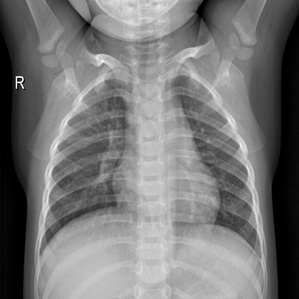

### RGB - PNEUMONIA

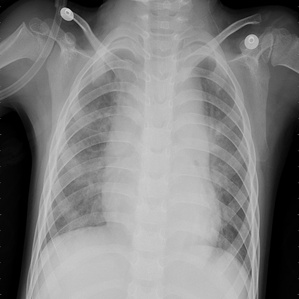

### GRAY - NORMAL

C:\Users\huawel\AppData\Local\Temp\ipykernel_26552\4152342440.py:36: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  return _Image.fromarray(a, mode='L')


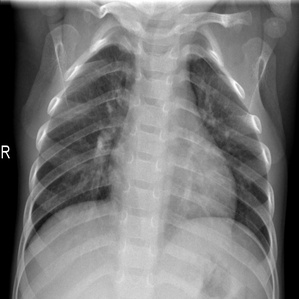

### GRAY - PNEUMONIA

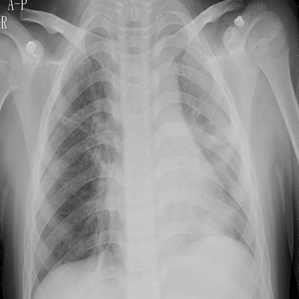

In [15]:
# Preview samples from normalized folders (RGB and grayscale)
# Displays one sample from each: RGB NORMAL, RGB PNEUMONIA, GRAY NORMAL, GRAY PNEUMONIA
# This version only displays inline and does NOT write PNG files to disk.

from pathlib import Path
import random
from IPython.display import display, Markdown

BASE = Path(r'd:/University_Large_files/Project')
paths = {
    'RGB - NORMAL': BASE / 'chest_xray_299_norm' / 'NORMAL',
    'RGB - PNEUMONIA': BASE / 'chest_xray_299_norm' / 'PNEUMONIA',
    'GRAY - NORMAL': BASE / 'chest_xray_299_gray_norm' / 'NORMAL',
    'GRAY - PNEUMONIA': BASE / 'chest_xray_299_gray_norm' / 'PNEUMONIA',
}


def _pick_sample(folder: Path):
    if not folder.exists():
        return None
    files = list(folder.glob('*.npy'))
    if not files:
        return None
    return random.choice(files)

for label, folder in paths.items():
    display(Markdown(f'### {label}'))
    p = _pick_sample(folder)
    if p is None:
        print(f'No .npy files found in: {folder}')
        continue
    # preview_npy (defined earlier) displays inline and returns a PIL Image
    try:
        _ = preview_npy(p, show=True, write_png=None)
    except Exception as e:
        print('Failed to preview', p, e)
